To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [89]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import geopandas as gpd
import shapely
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm_notebook as tqdm
tqdm().pandas();

# Coverage and Density of objects mapped


The following query gets all of the edits (ever), joined to changesets for all objects in Puerto Rico... it should take some time to download.

```sql
SELECT
  central_america.id, 
  geom,
  central_america.tags, changeset, updated, valid_until, version, minor_version,
  changesets.id AS c_id, 
  changesets.tags as c_tags,
  changesets.uid,
  changesets.user
  
FROM central_america

JOIN changesets on central_america.changeset = changesets.id

WHERE ST_WITHIN(
  geom , 
  ST_POLYGON('POLYGON((-67.3066 18.5729, -65.5553 18.5729, -65.5553 17.8729, -67.3066 17.8729, -67.3066 18.5729))'))
ORDER BY updated
```

In [91]:
# edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/116fe037-6c95-4517-b52b-de3ecc3ba763/csv')
#edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/5e4ea35a-0c61-4a79-8af0-77e18612ed13/csv')
edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/45b14013-55ee-49a3-98e2-6fb47e45302d/csv')


/www/45b14013-55ee-49a3-98e2-6fb47e45302d.csv
Creating dataframe... done.  Found 374,801 rows

In [92]:
place = "NW Puerto Rico"

In [93]:
edits.head(2)

,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user
0,53200463,POINT (-66.9724524 18.4951852),{created_by=JOSM},454478,2007-09-17 10:20:25.000,2008-12-13 23:42:48.000,1,0,454478,{},10019,Xaa
1,53200466,POINT (-67.0147075 18.5142),{created_by=JOSM},454478,2007-09-17 10:20:25.000,2008-12-13 23:42:48.000,1,0,454478,{},10019,Xaa


In [94]:
#Cast the date as date
edits['updated'] = edits.updated.progress_apply(pd.Timestamp)
edits['date'] = edits.updated.progress_apply(pd.Timestamp.date)

In [95]:
gb_date = edits.groupby('date').aggregate({
    'c_id':'count',
    'id':'nunique',
    'uid':'nunique'
});
gb_date.head(2)

,c_id,id,uid
date,,,
2007-09-17,9,9,1
2008-01-16,1531,1531,1


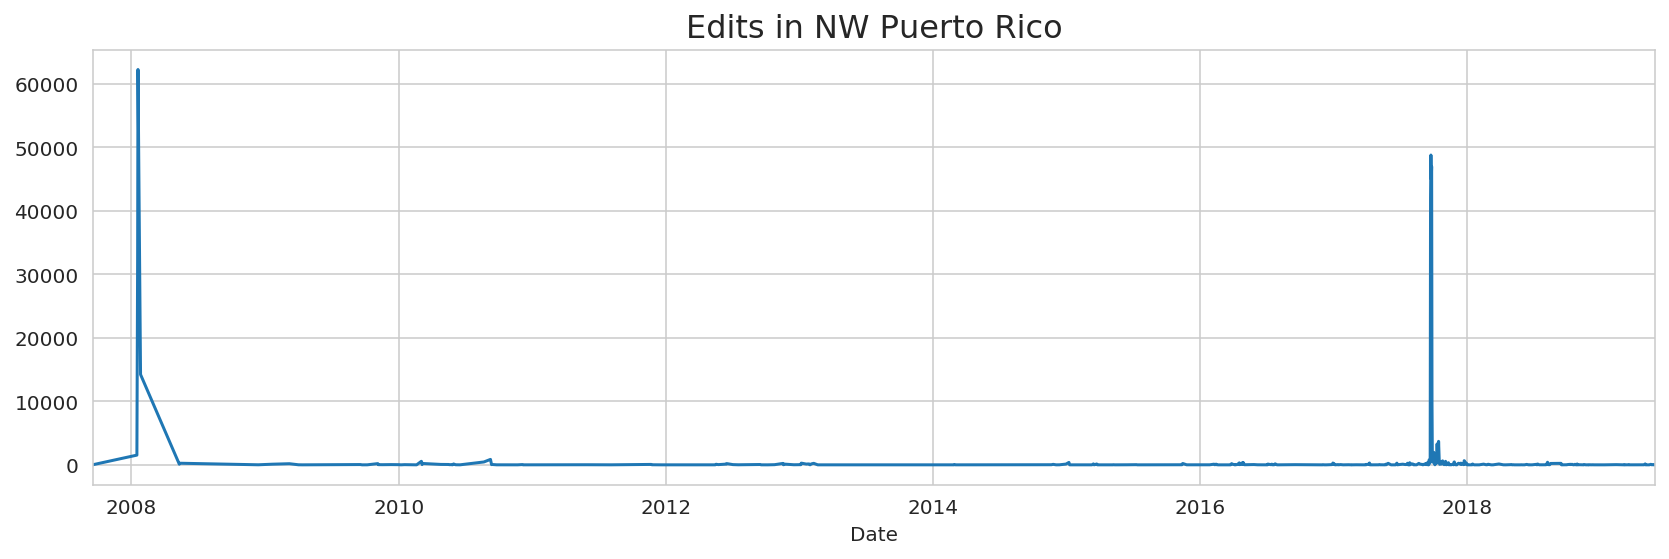

In [96]:
sns.set_style('whitegrid')
ax = gb_date['c_id'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Edits in {}".format(place),fontsize=16);

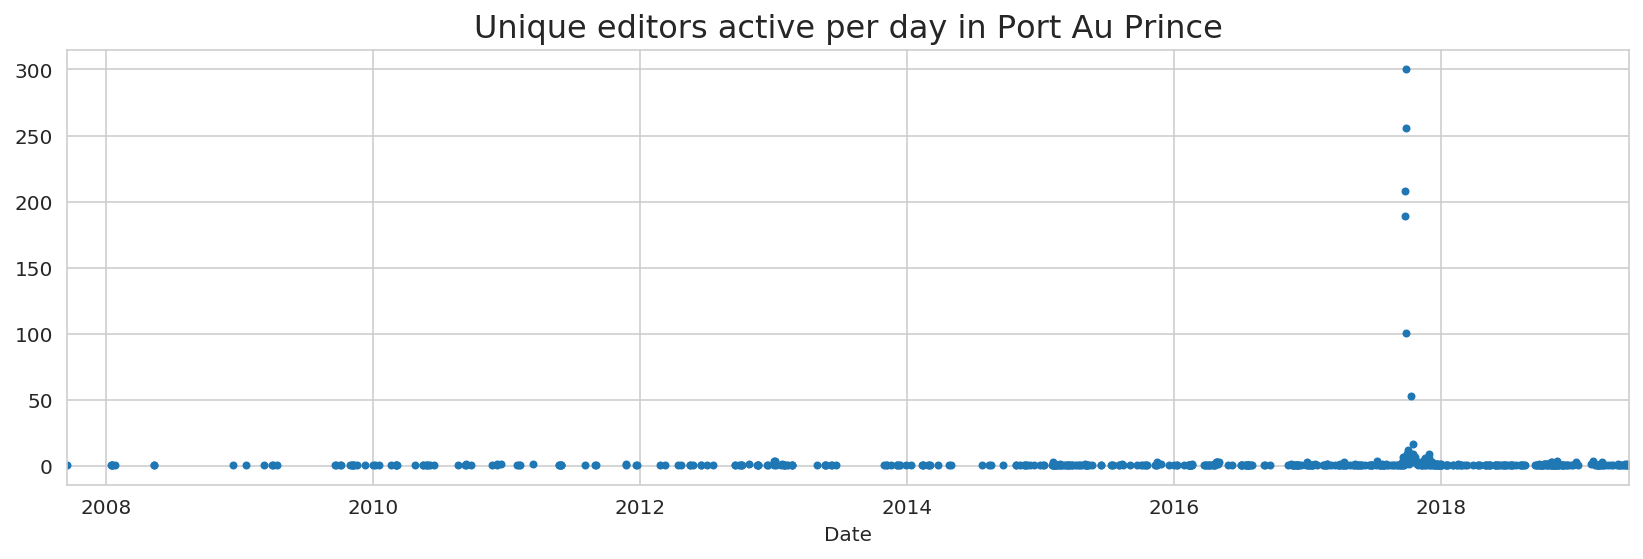

In [97]:
sns.set_style('whitegrid')
ax = gb_date['uid'].plot(style='.', figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Unique editors active per day in Port Au Prince",fontsize=16);

In [98]:
after_tiger = edits[edits.updated > datetime.datetime(2010,1,1)]

In [99]:
from shapely import wkt

In [120]:
sample2 = after_tiger.sample(100000)

In [122]:
sample2.geom = sample2.geom.progress_apply(wkt.loads)

In [102]:
points = gpd.GeoDataFrame(sample, geometry='geom')

In [123]:
sample2['date'] = sample2.updated.apply(lambda x: x.isoformat())

In [126]:
objects = gpd.GeoDataFrame(sample2, geometry='geom')

In [117]:
from keplergl import KeplerGl 
map_1 = KeplerGl(height=600)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [118]:
map_1

KeplerGl(height=600)

In [119]:
map_1.add_data(data=points[['geom','changeset','date','user']], name='points')

In [127]:
map_1.add_data(data=objects[['geom','changeset','date','user']], name='objects')

In [24]:
x.head()

,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user,date
223220,533065713,POINT (-67.05603391955104 18.0473433),{building=yes},53544737,2017-11-06 04:45:22,NaN,1,1,53544737,{comment=#hotosm-project-3716 #HurricaneMaria ...,6772516,goodone2,2017-11-06T04:45:22
579752,533475147,POINT (-66.60119308762668 18.0130146),{building=yes},53054707,2017-10-18 23:17:53,NaN,2,0,53054707,{hashtags=#hotosm-project-3671;#HurricaneMaria...,2690257,StevenFranklinHill,2017-10-18T23:17:53
96717,531612265,POINT (-66.69731350000001 18.28231925),{building=yes},54032889,2017-11-23 18:38:43,NaN,2,0,54032889,{hashtags=#hotosm-project-3696;#HurricaneMaria...,6554299,Birgit1961,2017-11-23T18:38:43
919405,528204808,POINT (-65.99371135000001 18.2054543),{building=yes},52858185,2017-10-12 12:07:24,NaN,2,0,52858185,{hashtags=#hotosm-project-3643;#HurricaneMaria...,6532561,EsthersGeo,2017-10-12T12:07:24
15004,22705965,POINT (-67.131895 18.460667),"{tiger:cfcc=A41, tiger:reviewed=no, name=Calle...",61505457,2018-08-09 15:41:43,NaN,2,0,61505457,"{host=https://www.openstreetmap.org/edit, imag...",8531481,Aguadilla City,2018-08-09T15:41:43


In [78]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def make_grid(length=0.1,width=0.1):
    xmin,ymin,xmax,ymax = points.total_bounds

    length = 0.1
    wide = 0.1

    cols = list(np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
    rows = list(np.arange(int(np.floor(ymin)), int(np.ceil(ymax)), length))
    rows.reverse()

    polygons = []
    ids = []; count=0
    for x in cols:
        for y in rows:
            count = count + 1
            ids.append(count)
            polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

    return gpd.GeoDataFrame({'geometry':polygons, 'PolyID':ids})

In [79]:
grid = make_grid()

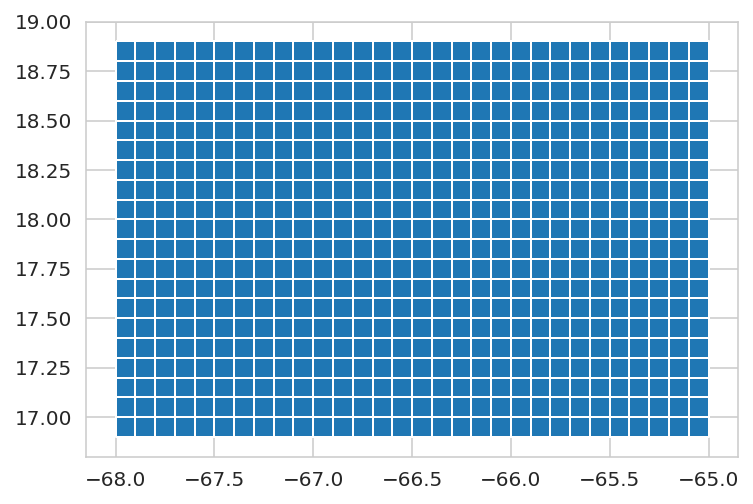

In [80]:
grid.plot()

In [87]:
dfsjoin = gpd.sjoin(grid,points) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='PolyID',columns='id',aggfunc={'id':len})
dfpivot.columns = dfpivot.columns.droplevel()

dfpolynew = grid.merge(dfpivot, how='left',on='PolyID')

In [88]:
dfpolynew.head()

,geometry,PolyID,900353,1191518,4430069,5889030,7727664,21652877,21653368,21653667,...,5969324157,5972770387,5972792002,6106367211,6175651620,6192578385,6271952213,6319680655,6416588872,6446619251
0,"POLYGON ((-68 18.90000000000003, -67.900000000...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-68 18.80000000000003, -67.900000000...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((-68 18.70000000000002, -67.900000000...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((-68 18.60000000000002, -67.900000000...",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((-68 18.50000000000002, -67.900000000...",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


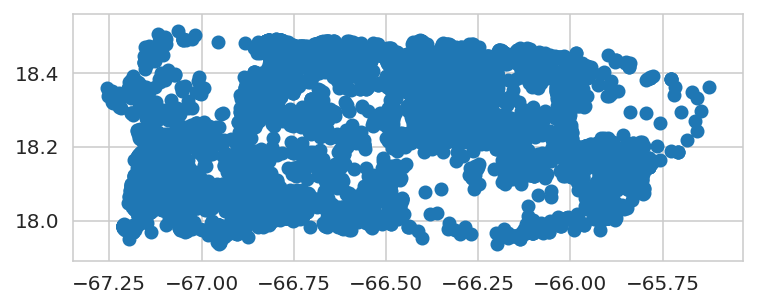

In [65]:
points.plot()